# Clustering particles

In [3]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

from tqdm import tqdm  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import clustering_particles as cp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [4]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

video_name = "3n_1m_2f_240216_1"
n_particles = int(video_name[0])
save_figures = True
save_tracking = True
x_bounds = [0, 1080]
y_bounds = [70, 1850]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Setting video information

In [5]:
# Load the video
reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# Check the number of frames
num_frames = reader.count_frames()
print("Total frames: {}".format(num_frames))

# Extract a frame to inspect the content
time = 0
frame = reader.get_data(time)
print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

Total frames: 108000
Frames resolution: 1080 x 1920


In [6]:
df_tracked = pd.concat([
    pd.read_csv("{}/tracked_{}_0.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_1.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_2.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_3.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_4.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_5.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_6.csv".format(output_path, video_name), low_memory=False),
    #pd.read_csv("{}/tracked_{}_7.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_8.csv".format(output_path, video_name), low_memory=False)
]).sort_values(["id", "time"])

In [7]:
if "coords_x" in df_tracked.columns:
    df_tracked["coords_x"] = df_tracked["coords_x"].apply(lambda x: np.fromstring(x, sep=" "))
    df_tracked["coords_y"] = df_tracked["coords_y"].apply(lambda x: np.fromstring(x, sep=" "))
df_tracked.sort_values(["time", "id"]).head(2 * n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,155.720896,141.717863,160.179170,126.715936,NaN,155.720896,141.717863,NaN,155.720896,141.717863,-0.835809,15496.0,237.280306,150.597248,0.772774,6
1,1,0,82.033846,201.990769,83.242722,201.009279,NaN,82.033846,201.990769,NaN,82.033846,201.990769,1.147757,325.0,156.253624,137.755181,0.471974,6
2,2,0,201.052560,503.068509,209.920424,507.448828,NaN,201.052560,503.068509,NaN,201.052560,503.068509,1.225347,11035.0,179.011263,95.679251,0.845176,6
3,3,0,1202.159988,978.965166,1195.283326,979.876593,0.0,1216.000000,928.000000,0.478431,1237.000000,966.000000,-1.264618,13751.0,252.252671,86.381723,0.939539,6
4,4,0,872.715415,1037.484190,888.266113,1034.640818,NaN,872.715415,1037.484190,NaN,872.715415,1037.484190,-1.480532,506.0,513.168091,83.594882,0.986643,6
5,5,0,29.969171,1052.553629,30.196906,1052.426001,0.0,46.000000,1023.000000,0.439216,0.000000,1051.000000,-0.958813,1557.0,98.473432,40.620537,0.910956,6


In [8]:
# Manual Setup for time = 0
tracking_0 = df_tracked[df_tracked["time"] == 0]
cols = ["id", "time", "id_count", "position_x", "position_y", "orientation"]
print("Initial tracking at time 0:\n", tracking_0[cols])

if tracking_0.shape[0] != n_particles:
    # Manual fitting of initial time tracking
    tracking_0 = tracking_0.drop_duplicates(subset=["id"], keep="first")
    tracking_0 = tracking_0[tracking_0["id"].isin([0, 2, 3])]
    tracking_0["id"] = np.arange(n_particles)
    tracking_0["orientation"] = np.array([
        tracking_0["orientation"].values[0],
        tracking_0["orientation"].values[1],
        tracking_0["orientation"].values[2]
    ])

    # Replace the manual setting
    df_tracked = pd.concat([
        tracking_0,
        df_tracked[df_tracked["time"] != 0]
    ]).sort_values(["id", "time"])

df_tracked.sort_values(["time", "id"]).head(2 * n_particles + 1)

Initial tracking at time 0:
    id  time  id_count   position_x   position_y  orientation
0   0     0         6   155.720896   141.717863    -0.835809
1   1     0         6    82.033846   201.990769     1.147757
2   2     0         6   201.052560   503.068509     1.225347
3   3     0         6  1202.159988   978.965166    -1.264618
4   4     0         6   872.715415  1037.484190    -1.480532
5   5     0         6    29.969171  1052.553629    -0.958813


,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,155.720896,141.717863,160.179170,126.715936,NaN,155.720896,141.717863,NaN,155.720896,141.717863,-0.835809,15496.0,237.280306,150.597248,0.772774,6
2,1,0,201.052560,503.068509,209.920424,507.448828,NaN,201.052560,503.068509,NaN,201.052560,503.068509,1.225347,11035.0,179.011263,95.679251,0.845176,6
3,2,0,1202.159988,978.965166,1195.283326,979.876593,0.0,1216.000000,928.000000,0.478431,1237.000000,966.000000,-1.264618,13751.0,252.252671,86.381723,0.939539,6
6,0,3,155.686042,141.752803,160.202156,126.767552,NaN,155.686042,141.752803,NaN,155.686042,141.752803,-0.835654,15518.0,237.319776,150.805765,0.772139,6
7,1,3,81.208589,201.907975,82.470701,200.967768,NaN,81.208589,201.907975,NaN,81.208589,201.907975,1.173184,326.0,155.699578,137.715809,0.466546,6
8,2,3,202.481328,516.389180,211.771307,522.238628,NaN,202.481328,516.389180,NaN,202.481328,516.389180,1.105022,12773.0,185.546963,99.303854,0.844728,6
9,3,3,1199.441574,981.667661,1192.309570,982.571977,0.0,1211.000000,933.000000,0.486275,1217.000000,966.000000,-1.305125,12734.0,244.032009,83.335724,0.939884,6


In [9]:
df_tracked.sort_values(["time", "id"]).tail(5)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
31289,0,107997,776.859054,17.411240,776.917977,17.411480,0.0,756.000000,0.000000,0.627451,812.000000,7.000000,-1.515751,2242.0,106.446646,34.083967,0.947351,5
31290,1,107997,72.509375,538.089845,72.563450,541.435764,0.0,85.000000,427.000000,0.482353,82.000000,637.000000,-0.117513,9227.0,267.631243,81.893294,0.952034,5
31291,2,107997,161.585399,939.906787,166.043703,937.333606,0.0,224.000000,890.000000,0.541176,180.000000,931.000000,-1.134934,8958.0,133.355018,90.215492,0.736437,5
31292,3,107997,256.347826,989.777778,256.526024,988.383760,NaN,256.347826,989.777778,NaN,256.347826,989.777778,-0.786599,207.0,131.683001,73.866910,0.827853,5
31293,4,107997,413.800889,999.117506,428.966468,990.960857,0.0,481.000000,934.000000,0.572549,500.000000,1000.000000,-1.150320,14178.0,242.054322,92.764615,0.923649,5


## Velocities distribution in each frame

In [10]:
omega_threshold = np.pi / 2 # Angular velocity per frame
velocity_threshold = 94.0 # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi)

# Compute differences for each id
df_tracked["delta_time"] = df_tracked.groupby(["id"])["time"].diff()
df_tracked["velocity_x"] = df_tracked.groupby(["id"])["position_x"].diff()
df_tracked["velocity_y"] = df_tracked.groupby(["id"])["position_y"].diff()
df_tracked["velocity_orientation"] = df_tracked.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_tracked["velocity_x"] = df_tracked["velocity_x"] / df_tracked["delta_time"]
df_tracked["velocity_y"] = df_tracked["velocity_y"] / df_tracked["delta_time"]
df_tracked["velocity_orientation"] = df_tracked["velocity_orientation"] / df_tracked["delta_time"]

# Filter short jumps (highest velocities are False)
df_tracked["mask_x"] = np.where(np.abs(df_tracked["velocity_x"]) <= velocity_threshold, True, False)
df_tracked["mask_y"] = np.where(np.abs(df_tracked["velocity_y"]) <= velocity_threshold, True, False)
df_tracked["mask_orientation"] = np.where(np.abs(df_tracked["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 94.0 
	- Angle: 90.0


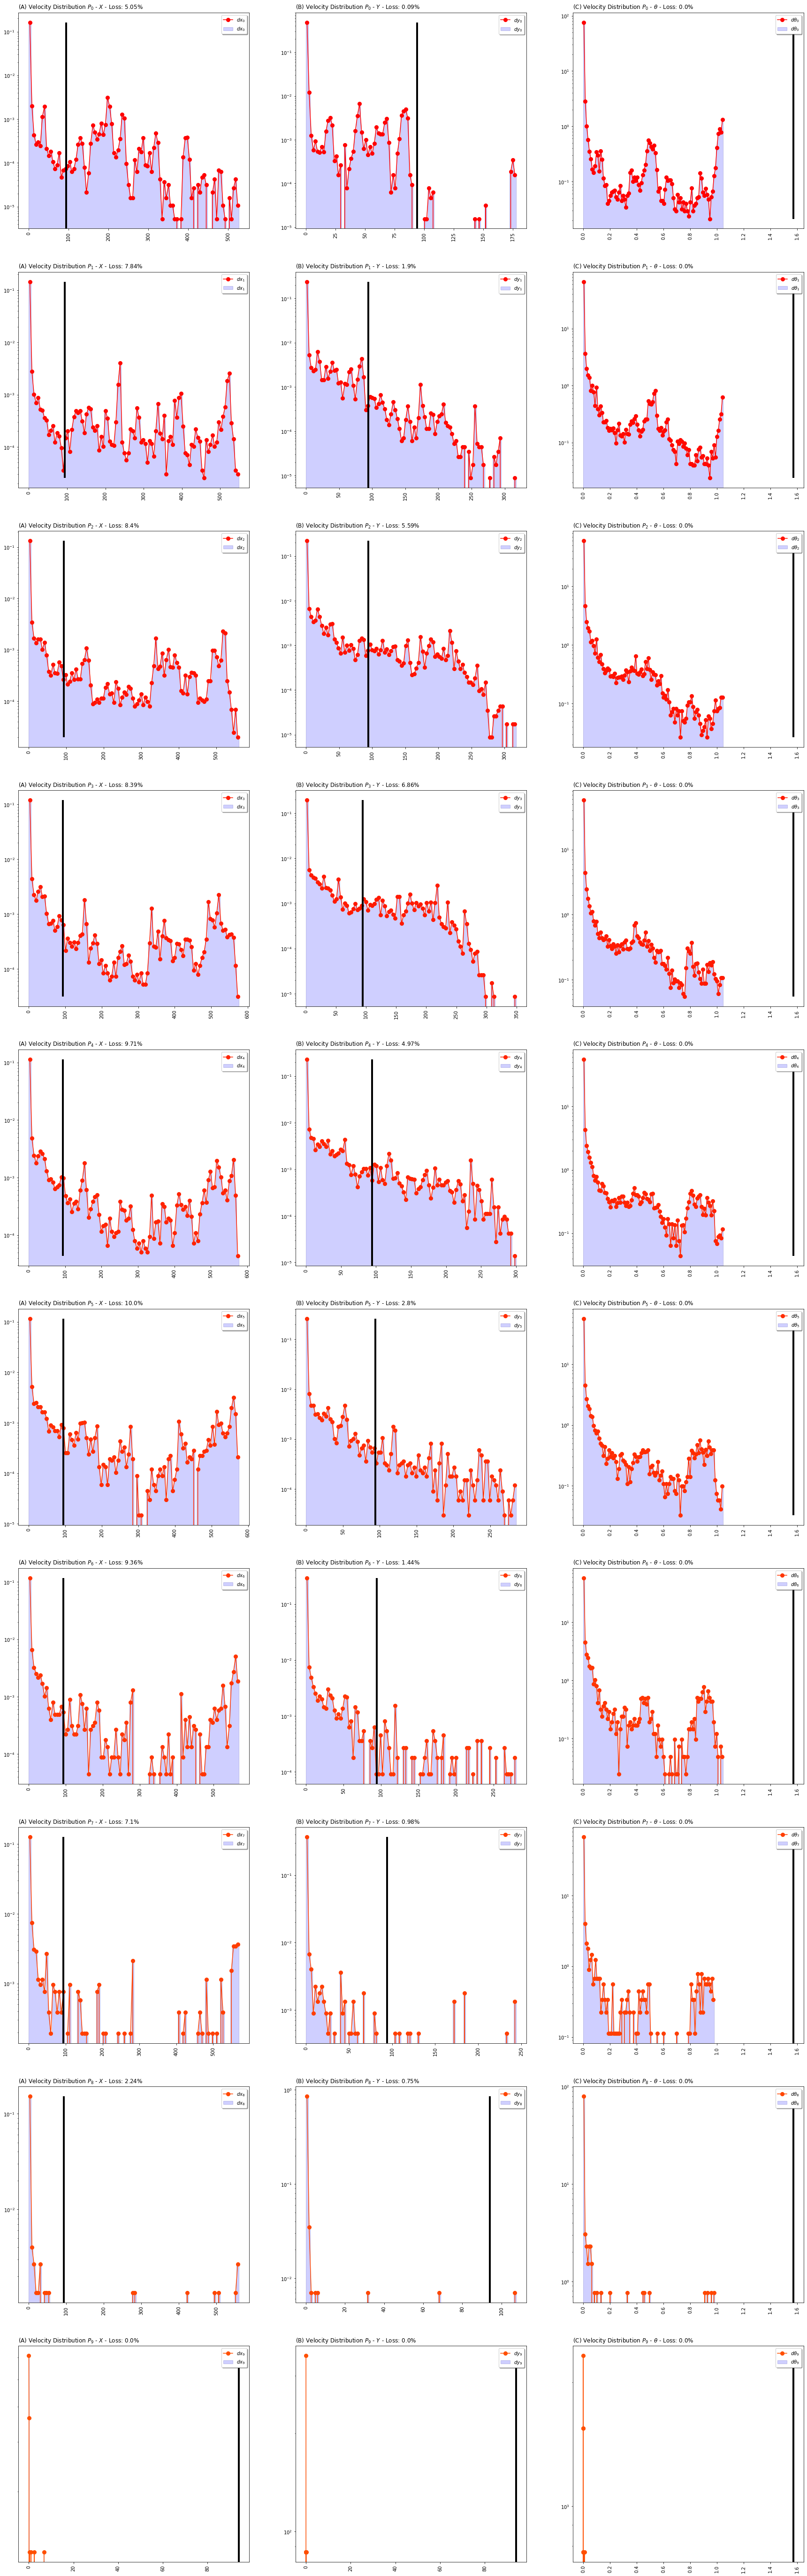

In [11]:
bins = 100
width = 10
fancy_legend = True

plt_cp.plot_velocities_distribution(
    df_tracked=df_tracked,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [12]:
df_tracked[["id_count"]].value_counts(dropna=False, sort=False, normalize=False).reset_index().sort_values("id_count")

,id_count,count
0,2,10
1,3,8907
2,4,36904
3,5,60635
4,6,46323
5,7,21259
6,8,6248
7,9,1089
8,10,130


## Clustering frames

In [13]:
# id_count = df_tracked["id_count"].max()
type = "local equalized"
clip_limit = 0.05
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = 100 # Velocity per frame limited with half average size of particle
compare_bounds = False
similarity_threshold = 0.85

print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
# ids = df_tracked[df_tracked["id_count"] != n_particles]["id_count"].unique()
# ids = sorted(np.sort(ids), key=lambda n: abs(n - n_particles))

df_clustered = cp.clustering_local_frames(
    reader=reader,
    df_tracked=df_tracked,
    weights_previous_time=[0],
    type=type,
    clip_limit=clip_limit,
    distance_threshold=velocity_threshold,
    compare_bounds=compare_bounds,
    similarity_threshold=similarity_threshold,
    n_particles=n_particles
)

Thresholds:
	- Velocity: 100 
	- Angle: 48.240414480046496 



In [14]:
df_clustered["id_count_new"] = df_clustered.groupby(["time"])["id"].transform("count")  # noqa: 501

### Explore final data

In [15]:
df_counts = (
    df_tracked[["id_count", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]
df_counts

,id_count,mask_x,mask_y,mask_orientation,proportion
0,2,False,False,False,0.005509
1,3,False,False,False,4.240104
2,3,False,True,False,0.188976
3,3,True,False,False,0.239663
4,3,True,True,False,0.238561
5,4,False,False,False,18.004463
6,4,False,True,False,0.602187
7,4,True,False,False,1.159748
8,4,True,True,False,0.565825
9,5,False,False,False,30.236082


In [16]:
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

# Compute differences for each id
df_clustered["delta_time"] = df_clustered.groupby(["id"])["time"].diff()
df_clustered["velocity_x"] = df_clustered.groupby(["id"])["position_x"].diff()
df_clustered["velocity_y"] = df_clustered.groupby(["id"])["position_y"].diff()
df_clustered["velocity_orientation"] = df_clustered.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_clustered["velocity_x"] = df_clustered["velocity_x"] / df_clustered["delta_time"]
df_clustered["velocity_y"] = df_clustered["velocity_y"] / df_clustered["delta_time"]
df_clustered["velocity_orientation"] = df_clustered["velocity_orientation"] / df_clustered["delta_time"]

# Filter short jumps (highest velocities are False)
df_clustered["mask_x"] = np.where(np.abs(df_clustered["velocity_x"]) <= velocity_threshold, True, False)
df_clustered["mask_y"] = np.where(np.abs(df_clustered["velocity_y"]) <= velocity_threshold, True, False)
df_clustered["mask_orientation"] = np.where(np.abs(df_clustered["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 41.340834960561295 
	- Angle: 48.240414480046496 



In [17]:
df_counts = (
    df_clustered[["id_count_new", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count_new", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]

print("Final loss data : {}%".format(df_counts[df_counts["id_count_new"]!=n_particles]["proportion"].sum()))
print("Final loss data X-axis: {}%".format(df_counts[df_counts["mask_x"]==False]["proportion"].sum()))
print("Final loss data Y-axis: {}%".format(df_counts[df_counts["mask_y"]==False]["proportion"].sum()))
print("Final loss data Angle : {}%".format(df_counts[df_counts["mask_orientation"]==False]["proportion"].sum()))
df_counts

Final loss data : 1.386461074208328%
Final loss data X-axis: 0.512447789206396%
Final loss data Y-axis: 0.37444569157451196%
Final loss data Angle : 0.7360111873700481%


,id_count_new,mask_x,mask_y,mask_orientation,proportion
0,2,False,False,False,0.000920
1,2,True,True,True,0.000920
2,3,False,False,False,0.016560
3,3,False,False,True,0.222643
4,3,False,True,False,0.025760
5,3,False,True,True,0.184923
6,3,True,False,False,0.001840
7,3,True,False,True,0.094761
8,3,True,True,False,0.655050
9,3,True,True,True,97.412001


In [18]:
df_filter_clustered = df_clustered[df_clustered["id_count_new"] == n_particles]
df_filter_clustered["id_count"] = df_filter_clustered["id_count_new"]
df_filter_clustered = df_filter_clustered.drop(columns=["id_count_new"])

Thresholds:
	- Velocity: 41.340834960561295 
	- Angle: 48.240414480046496 



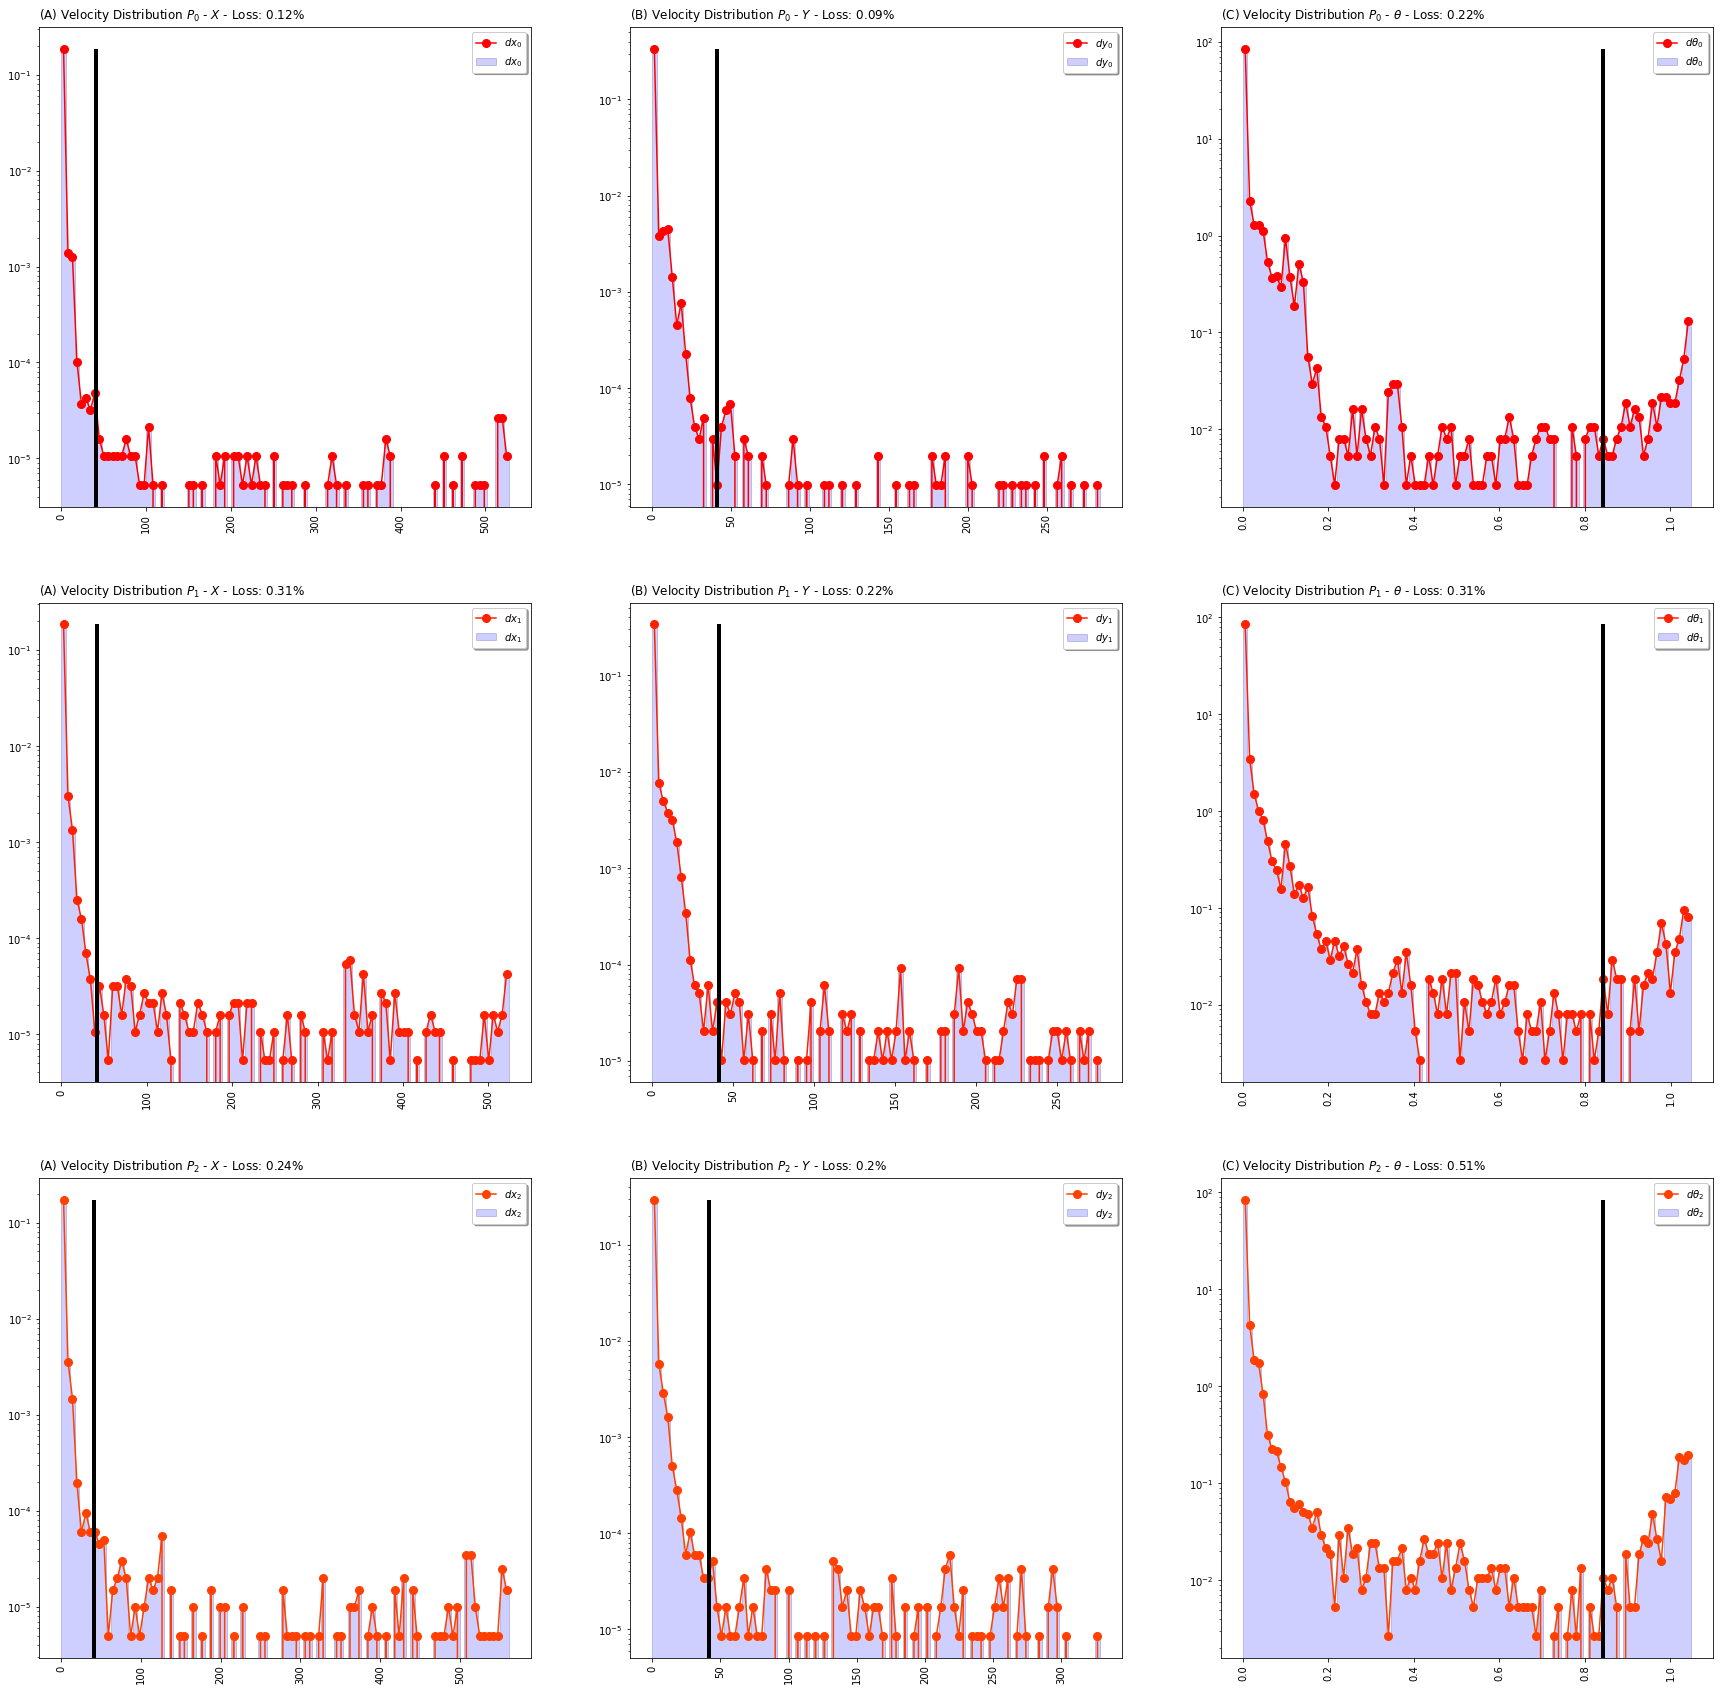

In [19]:
bins = 100
width = 10
fancy_legend = True
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

plt_cp.plot_velocities_distribution(
    df_tracked=df_filter_clustered,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [20]:
if "coords_x" in df_filter_clustered.columns:
    df_filter_clustered.drop(columns=["coords_x", "coords_y"]).to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)
else:
    df_filter_clustered.to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)

In [21]:
df_filter_clustered.head(n_particles * 3)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,155.720896,141.717863,160.179170,126.715936,NaN,155.720896,141.717863,NaN,155.720896,141.717863,-0.835809,15496.0,237.280306,150.597248,0.772774,3,NaN,NaN,NaN,NaN,False,False,False
2970,1,0,201.052560,503.068509,209.920424,507.448828,NaN,201.052560,503.068509,NaN,201.052560,503.068509,1.225347,11035.0,179.011263,95.679251,0.845176,3,NaN,NaN,NaN,NaN,False,False,False
5940,2,0,1202.159988,978.965166,1195.283326,979.876593,0.0,1216.000000,928.000000,0.478431,1237.000000,966.000000,-1.264618,13751.0,252.252671,86.381723,0.939539,3,NaN,NaN,NaN,NaN,False,False,False
8910,0,3,118.447315,171.830389,121.336429,163.867660,NaN,118.447315,171.830389,NaN,118.447315,171.830389,-0.835654,15518.0,237.319776,150.805765,0.772139,3,3.0,-12.424527,10.037509,0.000051,False,False,False
8911,1,3,202.481328,516.389180,211.771307,522.238628,NaN,202.481328,516.389180,NaN,202.481328,516.389180,1.105022,12773.0,185.546963,99.303854,0.844728,3,3.0,0.476256,4.440224,-0.040108,False,False,False
8912,2,3,1199.441574,981.667661,1192.309570,982.571977,0.0,1211.000000,933.000000,0.486275,1217.000000,966.000000,-1.305125,12734.0,244.032009,83.335724,0.939884,3,3.0,-0.906138,0.900832,-0.013502,False,False,False
8913,0,6,118.560074,172.032516,121.469915,164.083265,NaN,118.560074,172.032516,NaN,118.560074,172.032516,-0.845643,15286.0,238.254612,150.092103,0.776623,3,3.0,0.037586,0.067376,-0.003330,False,False,False
8914,1,6,202.859679,526.110728,212.516907,534.031219,NaN,202.859679,526.110728,NaN,202.859679,526.110728,0.970158,13348.0,194.875147,97.361014,0.866252,3,3.0,0.126117,3.240516,-0.044955,False,False,False
8915,2,6,1178.388136,986.973382,1171.479769,988.765538,NaN,1178.388136,986.973382,NaN,1178.388136,986.973382,-1.113872,14464.0,260.059397,88.249966,0.940662,3,3.0,-7.017813,1.768574,0.063751,False,False,False


## Visualize final data

In [22]:
width = 10
n_x_breaks = 20
n_y_breaks = 20
x_bounds = x_bounds  # Range: [0, 1080]
y_bounds = y_bounds  # Range: [0, 1920]
x_zoom = None  # x_zoom
y_zoom = None  # y_zoom
fancy_legend = True
x_legend = 1.001
y_legend = 0.821

if save_figures:
    df_data = df_filter_clustered[["time", "id_count", "id"]].drop_duplicates()
    df_data["id_included"] = True
    df_data["orientation_included"] = True

    # for time in tqdm(df_filter_clustered["time"].unique()):
    for time in tqdm([0, 10, 20, 50, 100]):
        plt_tp.plot_tracking_frame(
            reader=reader,
            df_tracked_frame=df_filter_clustered,
            width=width,
            n_x_breaks=n_x_breaks,
            n_y_breaks=n_y_breaks,
            x_bounds=x_bounds,
            y_bounds=y_bounds,
            x_zoom=x_zoom,
            y_zoom=y_zoom,
            fancy_legend=fancy_legend,
            x_legend=x_legend,
            y_legend=y_legend,
            save_figure=True,
            output_path=output_path,
            output_name="{}_c".format(video_name),
            time=time
        )

    df_data.to_csv("{}/{}_c/df_control.csv".format(output_path, video_name), index=False)


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


In [23]:
from shutil import make_archive

make_archive(
    "{}/{}_c".format(output_path, video_name),
    "zip",
    output_path,
    "{}/{}_c".format(output_path, video_name)
)

'/home/fabril/Github/High_Order_Interactions/tracking_videos/output_files/3n_1m_2f_240216_1_c.zip'